# 1. Library

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, mean_absolute_percentage_error
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import joblib
import pickle
import shap
import concurrent.futures
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
#from sktime.performance_metrics.forecasting import mean_squared_percentage_error, median_absolute_percentage_error, mean_relative_absolute_error, median_relative_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.optimizers import Adam

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
file_path = r'Z:\내 드라이브\Research\SavedData\KoSubway\df_subway_prep_20241117.csv'
df = pd.read_csv(file_path)
df

,날짜,호선,역명,시간,승차인원,하차인원,우대권인원수,청소년인원수,기온(°C),강수량(mm),...,λ_환승,λ_total,W_승차,W_환승,W_total,L_total,승강장_혼잡도,주,년도,월
0,2021-01-01,1,서울역,5,81,82,62,5,-9.7,0.0,...,0.045385,2.762052,2.8350,1.5,2.813064,7.769828,0.000719,1,2021,1
1,2021-01-01,1,서울역,5,81,82,62,5,-9.7,0.0,...,0.045385,2.762052,2.8350,1.5,2.813064,7.769828,0.000719,1,2021,1
2,2021-01-01,1,서울역,6,111,352,111,2,-9.7,0.0,...,0.128917,7.845583,2.6725,1.5,2.653234,20.816167,0.001927,1,2021,1
3,2021-01-01,1,서울역,6,111,352,111,2,-9.7,0.0,...,0.128917,7.845583,2.6725,1.5,2.653234,20.816167,0.001927,1,2021,1
4,2021-01-01,1,서울역,7,154,434,129,5,-9.3,0.0,...,0.163721,9.963721,2.2225,1.5,2.210628,22.026082,0.002039,1,2021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1649011,2023-12-31,8,잠실,21,1417,582,110,131,1.7,0.0,...,0.079932,33.396599,4.0000,1.5,3.994016,133.386565,0.008498,52,2023,12
1649012,2023-12-31,8,잠실,22,908,697,78,139,1.3,0.0,...,0.064178,26.814178,4.3825,1.5,4.375601,117.328141,0.007475,52,2023,12
1649013,2023-12-31,8,잠실,22,908,697,78,139,1.3,0.0,...,0.064178,26.814178,4.3825,1.5,4.375601,117.328141,0.007475,52,2023,12
1649014,2023-12-31,8,잠실,23,1569,1126,76,239,0.9,0.0,...,0.107762,45.024429,4.8250,1.5,4.817042,216.884560,0.013818,52,2023,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649016 entries, 0 to 1649015
Data columns (total 71 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   날짜            1649016 non-null  object 
 1   호선            1649016 non-null  int64  
 2   역명            1649016 non-null  object 
 3   시간            1649016 non-null  int64  
 4   승차인원          1649016 non-null  int64  
 5   하차인원          1649016 non-null  int64  
 6   우대권인원수        1649016 non-null  int64  
 7   청소년인원수        1649016 non-null  int64  
 8   기온(°C)        1649016 non-null  float64
 9   강수량(mm)       1649016 non-null  float64
 10  풍속(m/s)       1649016 non-null  float64
 11  습도(%)         1649016 non-null  int64  
 12  적설(cm)        1649016 non-null  float64
 13  승하차인원         1649016 non-null  int64  
 14  출입구           1649016 non-null  int64  
 15  섬식여부          1649016 non-null  int64  
 16  환승노선_개수       1649016 non-null  int64  
 17  면적            1649016 non-n

# 2. Prep

In [4]:
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # 수송인원 10개 필터링
    top_stations = ['홍대입구', '잠실', '강남', '서울역', '신림', '고속터미널', '신도림', '역삼', '선릉', '을지로입구'] 
    
    
    df = df[df['역명'].isin(top_stations)].reset_index(drop=True)
    
    selected_columns = df.columns
    
    # 제외할 변수 지정
    #excluded_columns = ['역명', '면적', '승강장혼잡도2', '승강장혼잡도1', '날짜', '수송인원수', 'L_total', 'λ_total',
     #                   'W_total', 'W_환승', 'λ_환승', 'W_승차', 'λ_승차', '승강장_혼잡도', '요일구분','승하차인원','일별_승하차인원_합','호선'
     #                   ,'시간대별_환승_승객_수','시간대별_승하차_비율']
    
   # feature_columns = [col for col in selected_columns if col not in excluded_columns]

    # 공공데이터포털 DB만 사용.
    feature_columns = ['주', '년도', '월', '공휴일여부', '요일_Monday', '요일_Tuesday', '요일_Wednesday', '요일_Thursday', '요일_Friday', 
                       '요일_Saturday', '요일_Sunday', '시간', '승차인원', '하차인원', '우대권인원수', '청소년인원수', 
                       '상선 혼잡도', '하선 혼잡도', '환승유입인원수', '섬식여부', '출입구', '환승노선_개수', '수송인원수']
    
    # 독립 변수와 종속 변수 분리
    X = df[feature_columns]
    y = df['승강장혼잡도1']
    
    # 학습용과 테스트용 데이터로 분할
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 결과를 딕셔너리 형태로 반환
    data = {
        'X_train': X_train,
        'Y_train': Y_train,
        'X_test': X_test,
        'Y_test': Y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'feature_columns': feature_columns,
        'scaler': scaler,  # 추가
        'df_train': df.iloc[X_train.index],
        'df_test': df.iloc[X_test.index]
    }
    
    return data

# 데이터 전처리
data = preprocess_data(file_path)

In [5]:
def mean_squared_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  
    return np.mean(((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2)

def median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

# 3. Model

In [6]:
def model_linear(X_train_scaled, Y_train):
    model = LinearRegression()
    model.fit(X_train_scaled, Y_train)
    return model

def model_rf(X_train_scaled, Y_train):
    model = RandomForestRegressor(n_estimators=50, random_state=0)
    model.fit(X_train_scaled, Y_train)
    return model

def model_xgb(X_train_scaled, Y_train):
    params = {
        'n_estimators': 100,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'random_state': 0
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_scaled, Y_train)
    return model

def model_lightgbm(X_train_scaled, Y_train):
    model = lgb.LGBMRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=0)
    model.fit(X_train_scaled, Y_train)
    return model

def model_catboost(X_train_scaled, Y_train):
    model = CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_state=0, silent=True)
    model.fit(X_train_scaled, Y_train)
    return model

def model_mlp(X_train_scaled, Y_train):
    model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=0)
    model.fit(X_train_scaled, Y_train)
    return model

def model_cnn(X_train_scaled, Y_train):
    X_train_scaled_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    
    model = Sequential([
        Conv1D(64, kernel_size=2, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train_scaled_reshaped, Y_train, epochs=10, batch_size=32, verbose=0)
    
    return model

In [7]:
def calculate_metrics(Y_true, Y_pred):
    return {
        'mse': mean_squared_error(Y_true, Y_pred),
        'rmse': mean_squared_error(Y_true, Y_pred, squared=False),
        'mspe': mean_squared_percentage_error(Y_true, Y_pred),
        'mae': mean_absolute_error(Y_true, Y_pred),
        'medae': median_absolute_error(Y_true, Y_pred),
        'medape': median_absolute_percentage_error(Y_true, Y_pred)
    }

# 4. 평가

In [8]:
# 모델들을 딕셔너리로 정의
models = {
    'Linear Regression': model_linear,
    'Random Forest': model_rf,
    'XGBoost': model_xgb,
    'LightGBM': model_lightgbm,
    'CatBoost': model_catboost,
    'MLP': model_mlp,
    'CNN': model_cnn
}

# 결과 저장을 위한 빈 리스트 초기화
result_list = []

# 모델 학습 및 저장
trained_models = {}
for model_name, model_func in models.items():
    print(f'--- {model_name} 모델 학습 ---')
    if model_name == 'CNN':
        X_train_model_input = data['X_train_scaled'].reshape(-1, data['X_train_scaled'].shape[1], 1)
    else:
        X_train_model_input = data['X_train_scaled']
    best_model = model_func(X_train_model_input, data['Y_train'])
    trained_models[model_name] = best_model

--- Linear Regression 모델 학습 ---
--- Random Forest 모델 학습 ---
--- XGBoost 모델 학습 ---
--- LightGBM 모델 학습 ---


  File "C:\Users\KK\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\KK\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\KK\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\KK\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2165
[LightGBM] [Info] Number of data points in the train set: 442635, number of used features: 23
[LightGBM] [Info] Start training from score 59.943059
--- CatBoost 모델 학습 ---
--- MLP 모델 학습 ---
--- CNN 모델 학습 ---


In [9]:
top_stations = ['홍대입구', '잠실', '강남', '서울역', '신림', '고속터미널', '신도림', '역삼', '선릉', '을지로입구']

def evaluate_station_model(station_name):
    station_results = []
    station_data = data['df_test'][data['df_test']['역명'] == station_name]
    lines = station_data['호선'].unique()
    
    for line in lines:
        line_data = station_data[station_data['호선'] == line]
        X_test_station_scaled = data['scaler'].transform(line_data[data['feature_columns']])
        Y_test_station = line_data['승강장혼잡도1']
        
        for model_name, best_model in trained_models.items():
            print(f'\n\n--- {station_name} ({line}호선) - {model_name} 모델 학습 및 평가 ---\n')
            try:
                if model_name == 'CNN':
                    X_test_model_input = X_test_station_scaled.reshape(-1, X_test_station_scaled.shape[1], 1)
                else:
                    X_test_model_input = X_test_station_scaled

                # 예측값 계산
                Y_test_pred = best_model.predict(X_test_model_input)
                if model_name == 'CNN':
                    Y_test_pred = Y_test_pred.flatten()

                # 성능 지표 계산
                test_metrics = calculate_metrics(Y_test_station, Y_test_pred)

                result = {
                    '역명': station_name,
                    '호선': line,
                    '알고리즘': model_name,
                    '실제값 평균': round(Y_test_station.mean(), 6),
                    '예측값 평균': round(Y_test_pred.mean(), 6),
                    'MSE': round(test_metrics['mse'], 6),
                    'RMSE': round(test_metrics['rmse'], 6),
                    'MSPE': round(test_metrics['mspe'], 6),
                    'MAE': round(test_metrics['mae'], 6),
                    'MAPE': round(mean_absolute_percentage_error(Y_test_station, Y_test_pred), 6),
                    'MedAE': round(test_metrics['medae'], 6),
                    'MedAPE': round(test_metrics['medape'], 6)
                }
                station_results.append(result)
            except Exception as e:
                print(f"{station_name} ({line}호선) - {model_name} 모델 평가 중 오류 발생: {e}")
    return station_results


    
# 병렬 실행
with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
    futures = [executor.submit(evaluate_station_model, station_name) for station_name in top_stations]
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result:
            result_list.extend(result)

# 최종 결과 데이터프레임 생성
final_results_df = pd.DataFrame(result_list)



--- 홍대입구 (2호선) - Linear Regression 모델 학습 및 평가 ---



--- 잠실 (2호선) - Linear Regression 모델 학습 및 평가 ---



--- 강남 (2호선) - Linear Regression 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - Random Forest 모델 학습 및 평가 ---



--- 서울역 (1호선) - Linear Regression 모델 학습 및 평가 ---



--- 강남 (2호선) - Random Forest 모델 학습 및 평가 ---



--- 잠실 (2호선) - Random Forest 모델 학습 및 평가 ---



--- 서울역 (1호선) - Random Forest 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - XGBoost 모델 학습 및 평가 ---



--- 잠실 (2호선) - XGBoost 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - LightGBM 모델 학습 및 평가 ---



--- 잠실 (2호선) - LightGBM 모델 학습 및 평가 ---



--- 서울역 (1호선) - XGBoost 모델 학습 및 평가 ---



--- 강남 (2호선) - XGBoost 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - CatBoost 모델 학습 및 평가 ---



--- 잠실 (2호선) - CatBoost 모델 학습 및 평가 ---



--- 서울역 (1호선) - LightGBM 모델 학습 및 평가 ---



--- 강남 (2호선) - LightGBM 모델 학습 및 평가 ---



--- 홍대입구 (2호선) - MLP 모델 학습 및 평가 ---



--- 잠실 (2호선) - MLP 모델 학습 및 평가 ---



--- 서울역 (1호선) - CatBoost 모델 학습 및 평가 ---



--- 강남 (2호선) - CatBoost 모델 학습 및 평가 ---



--- 강남 (2호선) - 

In [10]:
pd.set_option('display.max_rows', None)
final_results_df

,역명,호선,알고리즘,실제값 평균,예측값 평균,MSE,RMSE,MSPE,MAE,MAPE,MedAE,MedAPE
0,홍대입구,2,Linear Regression,102.607423,88.897116,232.850597,15.259443,0.040612,13.785619,0.167758,13.752513,13.247685
1,홍대입구,2,Random Forest,102.607423,102.643671,0.400766,0.633061,0.000047,0.263738,0.002898,0.109493,0.131276
2,홍대입구,2,XGBoost,102.607423,102.191963,12.672134,3.559794,0.003348,2.641306,0.036989,1.991667,2.298541
3,홍대입구,2,LightGBM,102.607423,102.054004,15.668615,3.958360,0.002846,2.964262,0.038000,2.291394,2.772313
4,홍대입구,2,CatBoost,102.607423,101.612850,20.997387,4.582291,0.004476,3.280274,0.041786,2.415947,2.953847
5,홍대입구,2,MLP,102.607423,102.832876,0.134090,0.366183,0.000103,0.285783,0.004322,0.236504,0.271791
6,홍대입구,2,CNN,102.607423,102.565254,0.169086,0.411201,0.000216,0.317263,0.005641,0.251604,0.282209
7,강남,2,Linear Regression,146.920402,124.970851,1005.709202,31.712919,0.180404,24.995145,0.230454,20.711069,16.599509
8,강남,2,Random Forest,146.920402,146.847872,0.419855,0.647963,0.000062,0.286545,0.002812,0.131890,0.109943
9,강남,2,XGBoost,146.920402,146.388092,22.912268,4.786676,0.003113,3.326729,0.031537,2.356520,1.999836


# 5. 시각화

Error plotting predictions for Linear Regression: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for Random Forest: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for XGBoost: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for LightGBM: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for CatBoost: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for MLP: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for CNN: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.


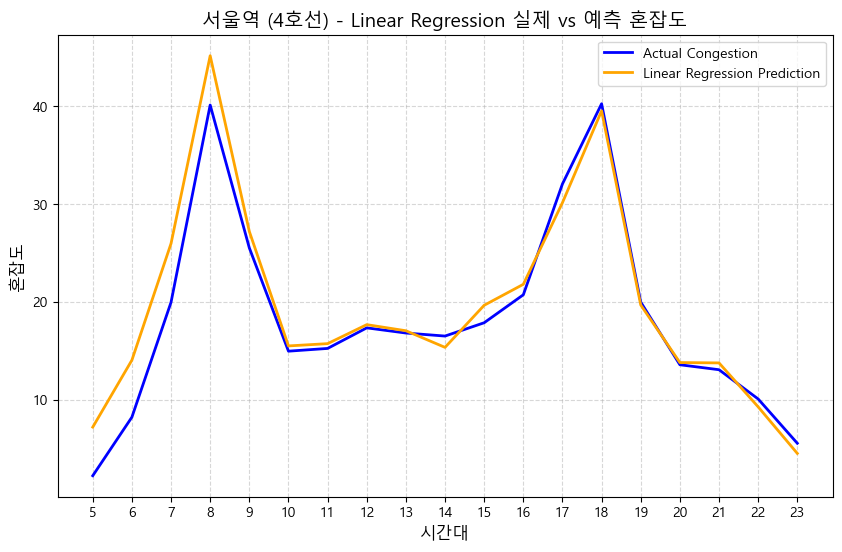

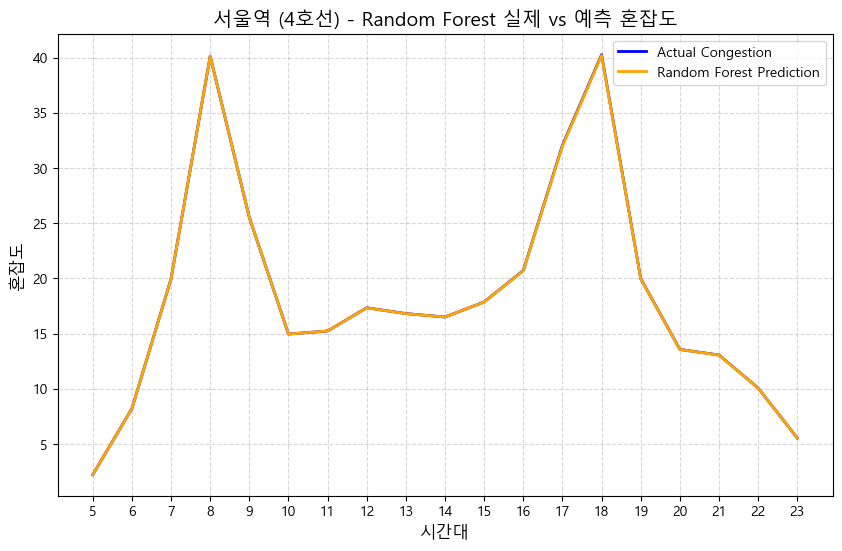

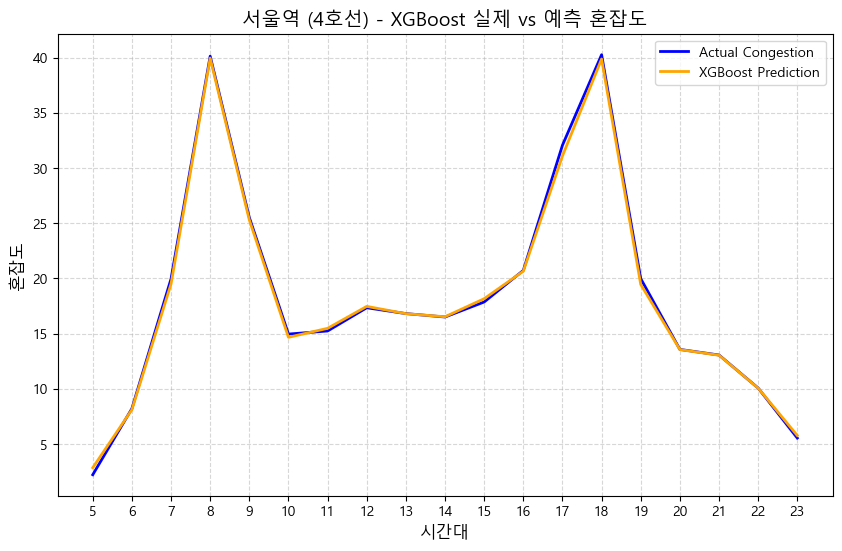

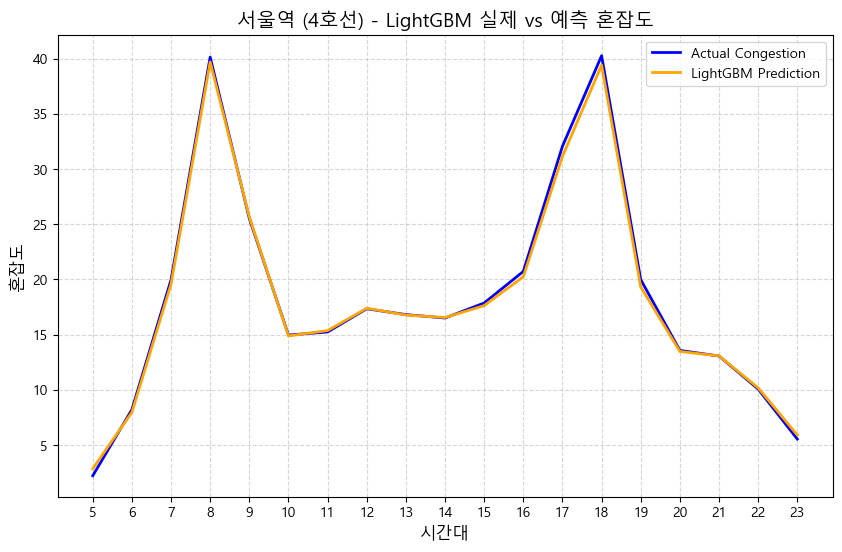

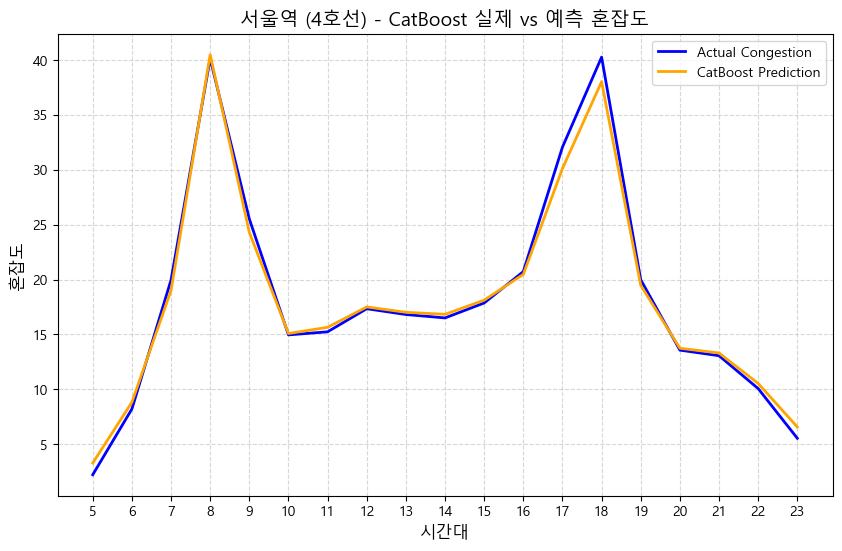

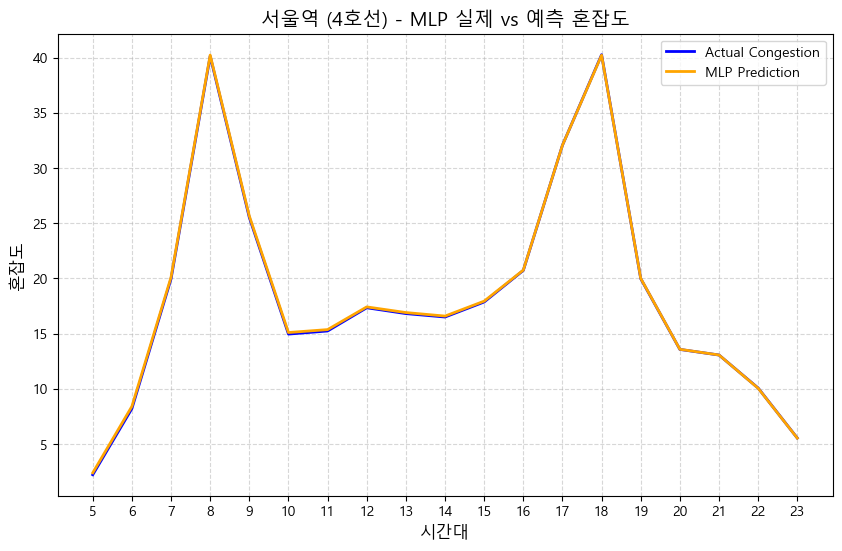

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step


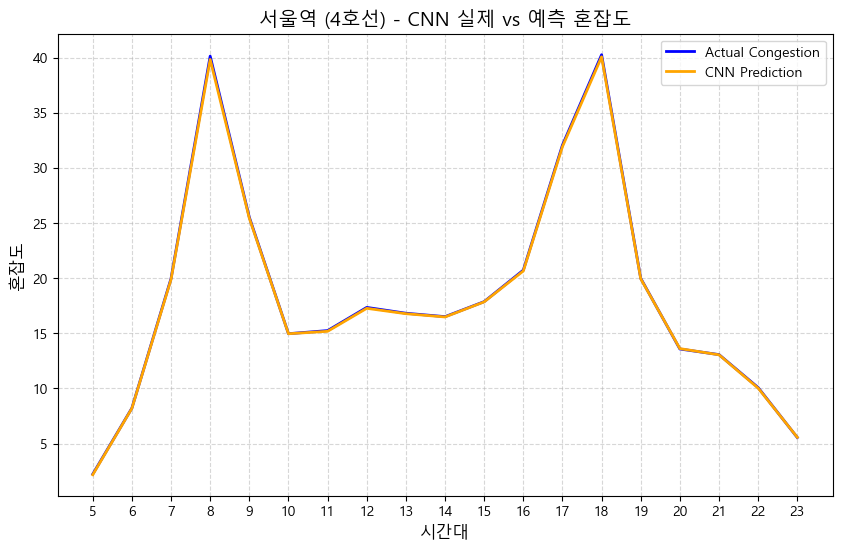

In [11]:
def plot_2d(station_name, line_number):
    
    station_data = data['df_test'][(data['df_test']['역명'] == station_name) & 
                                   (data['df_test']['호선'] == line_number)]
    
    # 시간대별 실제 혼잡도 평균 계산 및 정렬
    station_data = station_data.sort_values(by='시간')
    time_series = station_data['시간'].unique()
    actual_congestion = station_data.groupby('시간')['승강장혼잡도1'].mean()
    
    # 모델별 예측값 시각화
    for model_name, best_model in trained_models.items():
        try:
            X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
            if model_name == 'CNN':
                X_test_model_input = X_test_station_scaled.reshape(-1, X_test_station_scaled.shape[1], 1)
            else:
                X_test_model_input = X_test_station_scaled

            # 예측
            Y_test_pred = best_model.predict(X_test_model_input)
            if model_name == 'CNN':
                Y_test_pred = Y_test_pred.flatten()
            
            # 시간대별 예측 값 평균 
            predicted_congestion = [Y_test_pred[station_data['시간'] == t].mean() for t in time_series]
            
            plt.figure(figsize=(10, 6))
            plt.plot(time_series, actual_congestion, label='Actual Congestion', color='blue', linewidth=2)
            plt.plot(time_series, predicted_congestion, label=f'{model_name} Prediction', color='orange', linewidth=2)
            plt.title(f'{station_name} ({line_number}호선) - {model_name} 실제 vs 예측 혼잡도', fontsize=14)
            plt.xlabel('시간대', fontsize=12)
            plt.ylabel('혼잡도', fontsize=12)
            plt.xticks(time_series)
            plt.grid(visible=True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Error plotting predictions for {model_name}: {e}")

# 출력(서울역과 을지로입구역)
plot_2d('강남역', 2)
plot_2d('서울역', 4)

Error plotting predictions for Linear Regression: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for Random Forest: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for XGBoost: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for LightGBM: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for CatBoost: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for MLP: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.
Error plotting predictions for CNN: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required by StandardScaler.


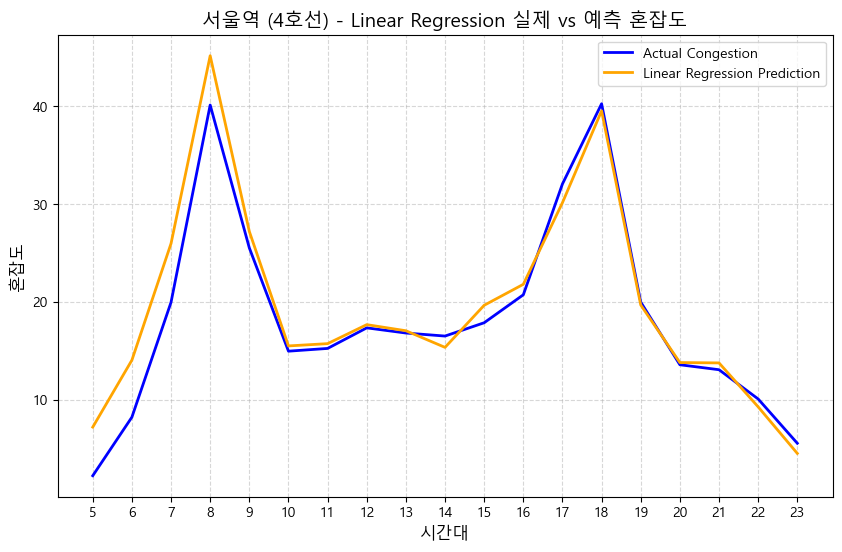

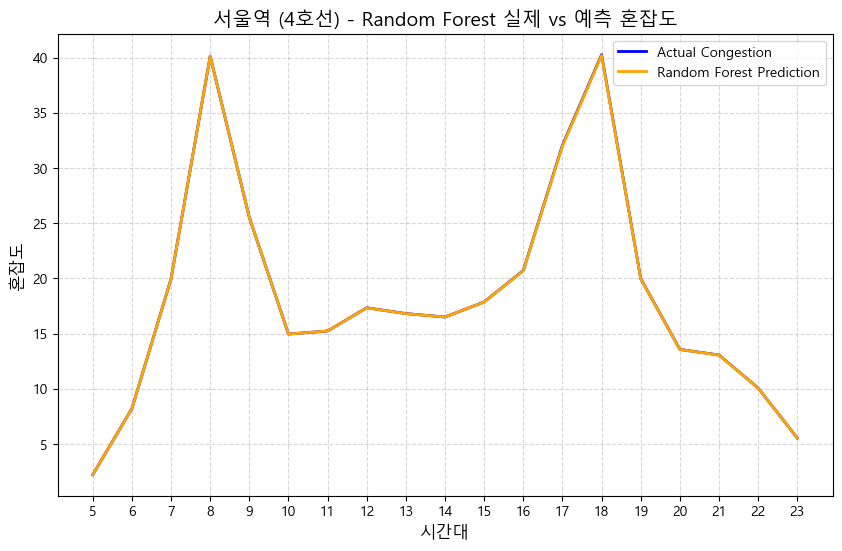

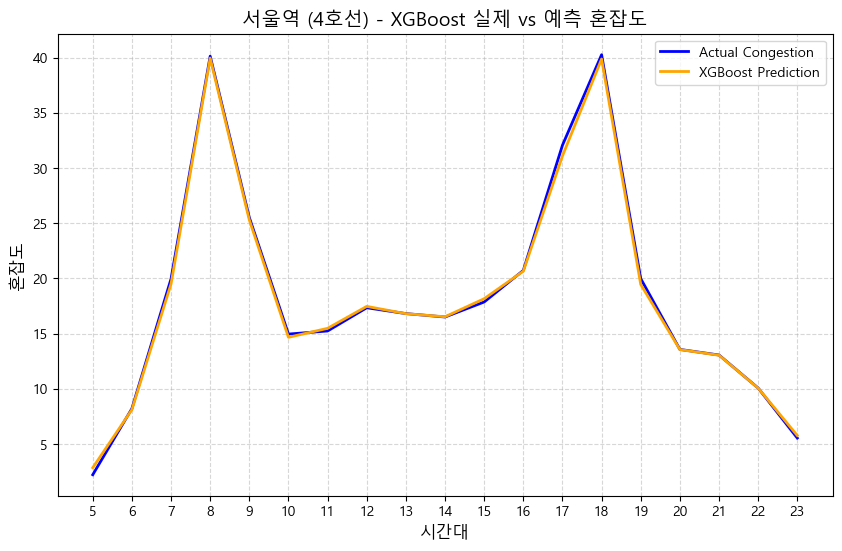

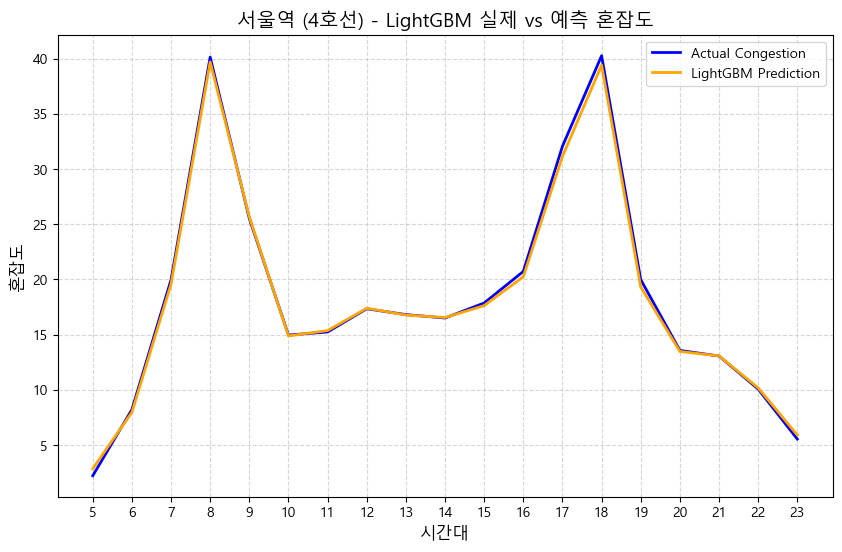

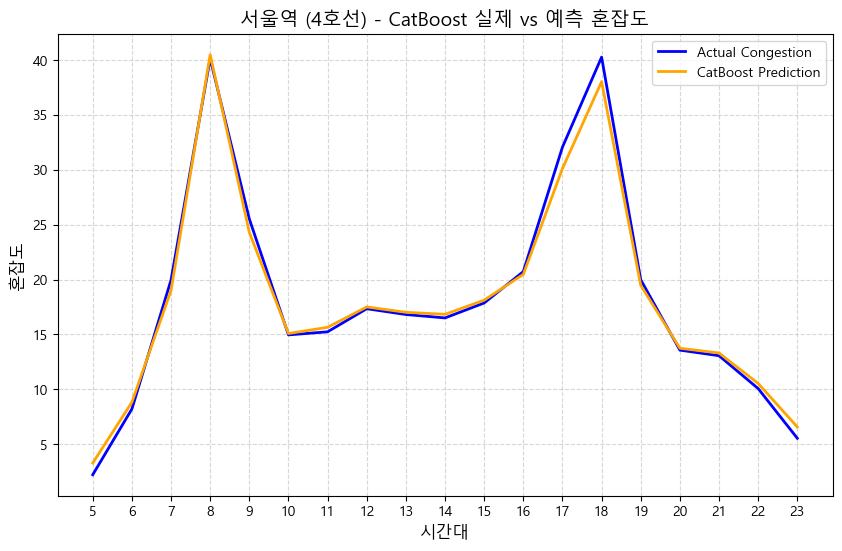

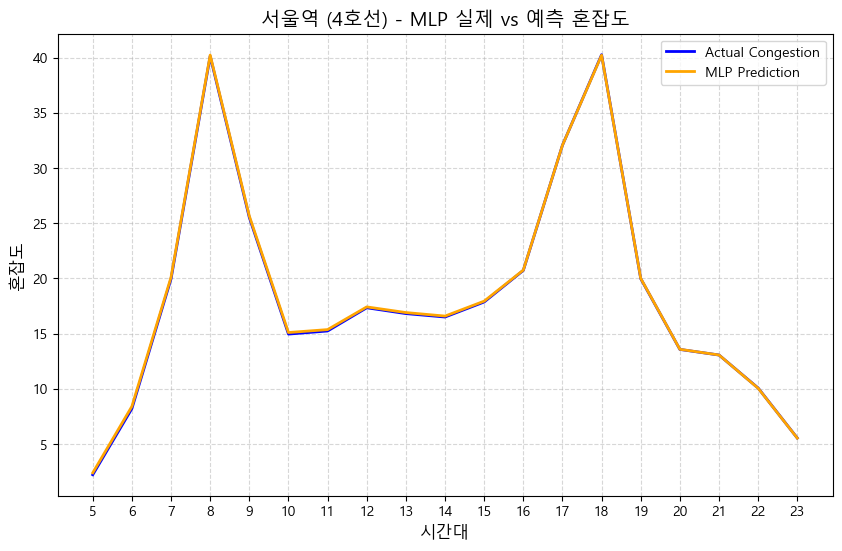

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step


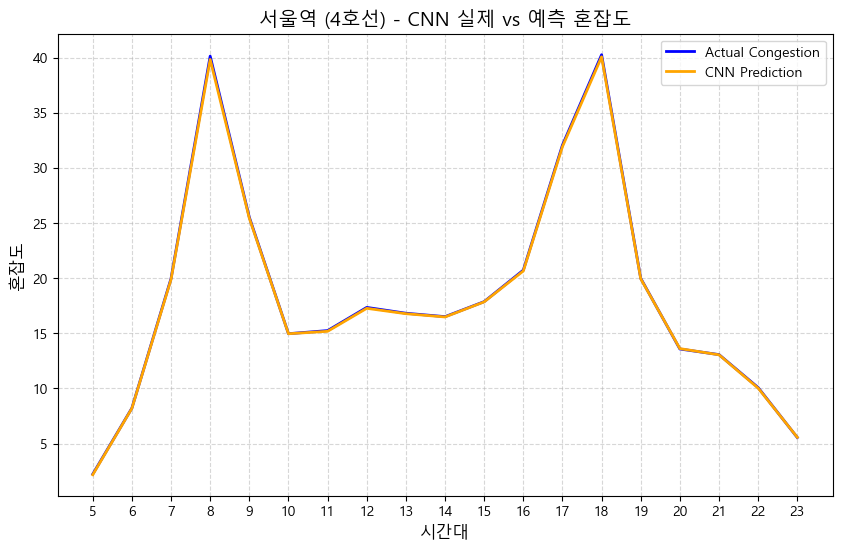

In [12]:
def plot_2d_2(station_name, line_number):
    station_data = data['df_test'][(data['df_test']['역명'] == station_name) & 
                                   (data['df_test']['호선'] == line_number)]
    
    # 순서대로 정렬
    station_data = station_data.sort_values(by='월')
    monthly_series = sorted(station_data['월'].unique())
    actual_congestion = station_data.groupby('월')['승강장혼잡도1'].mean()
    
    # 모델별 예측값 시각화
    for model_name, best_model in trained_models.items():
        try:
            X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
            if model_name == 'CNN':
                X_test_model_input = X_test_station_scaled.reshape(-1, X_test_station_scaled.shape[1], 1)
            else:
                X_test_model_input = X_test_station_scaled

            # 예측
            Y_test_pred = best_model.predict(X_test_model_input)
            if model_name == 'CNN':
                Y_test_pred = Y_test_pred.flatten()
            
            # 월별 예측 값 평균 계산
            predicted_congestion = [Y_test_pred[station_data['월'] == month].mean() for month in monthly_series]
            
            plt.figure(figsize=(10, 6))
            plt.plot(monthly_series, actual_congestion, label='Actual Congestion', color='blue')
            plt.plot(monthly_series, predicted_congestion, label=f'{model_name} Prediction', color='orange', linewidth=2)
            plt.title(f'{station_name} ({line_number}호선) - 월별 {model_name} 실제 vs 예측 혼잡도', fontsize=14)
            plt.xlabel('월', fontsize=12)
            plt.ylabel('혼잡도', fontsize=12)
            plt.xticks(monthly_series)
            plt.grid(visible=True, linestyle='--', alpha=0.5)
            plt.legend()
            plt.show()
        except Exception as e:
            print(f"Error plotting predictions for {model_name}: {e}")

# 출력
plot_2d('강남역', 2)
plot_2d('서울역', 4)

# 6. Shap 분석

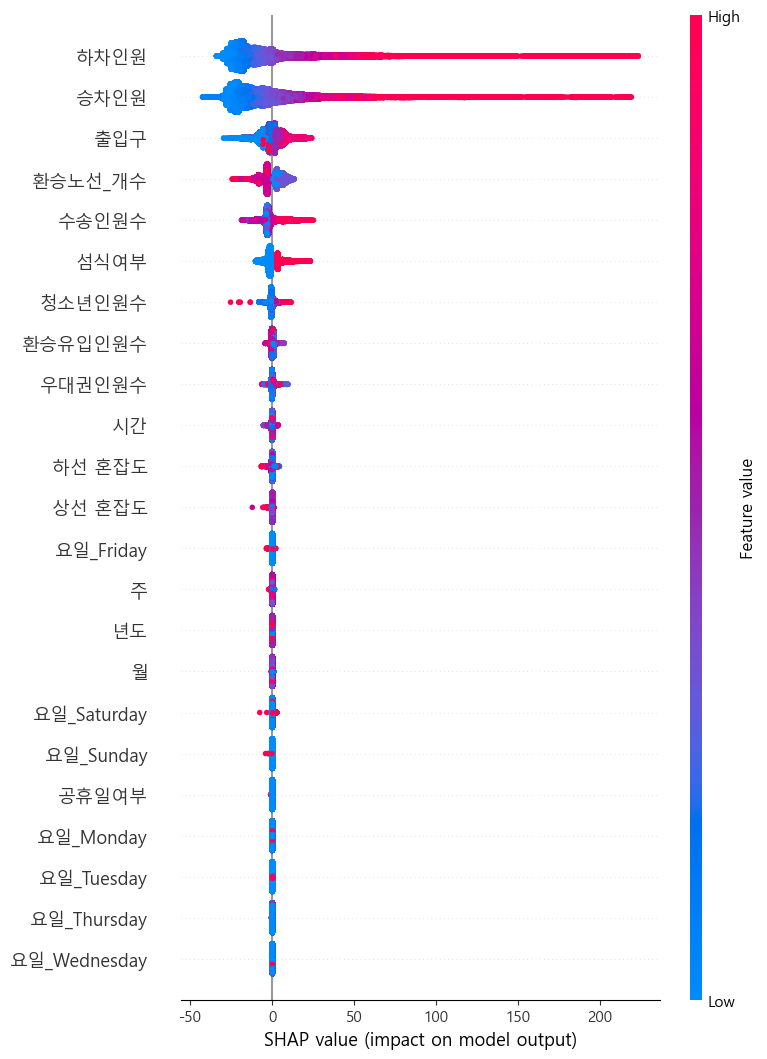

In [15]:
best_xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=0)
best_xgb_model.fit(data['X_train_scaled'], data['Y_train'])

# SHAP 분석
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(data['X_test_scaled'])

# SHAP 요약 플롯
shap.summary_plot(shap_values, data['X_test'], feature_names=data['feature_columns'], max_display=100)

In [16]:
# # 제외할 변수 목록
# exclude_features = ['하차인원', '승차인원']

# # 제외할 변수의 인덱스를 찾음
# exclude_indices = [data['feature_columns'].index(feature) for feature in exclude_features]

# # 제외한 SHAP 값 및 데이터 생성
# shap_values_filtered = shap_values.copy()
# shap_values_filtered = np.delete(shap_values_filtered, exclude_indices, axis=1)

# # 제외한 데이터셋 생성
# X_test_filtered = data['X_test'].copy()
# X_test_filtered = X_test_filtered.drop(columns=exclude_features)

# # 제외된 변수를 반영한 SHAP 요약 플롯
# shap.summary_plot(shap_values_filtered, X_test_filtered, feature_names=X_test_filtered.columns.tolist(), max_display=100)

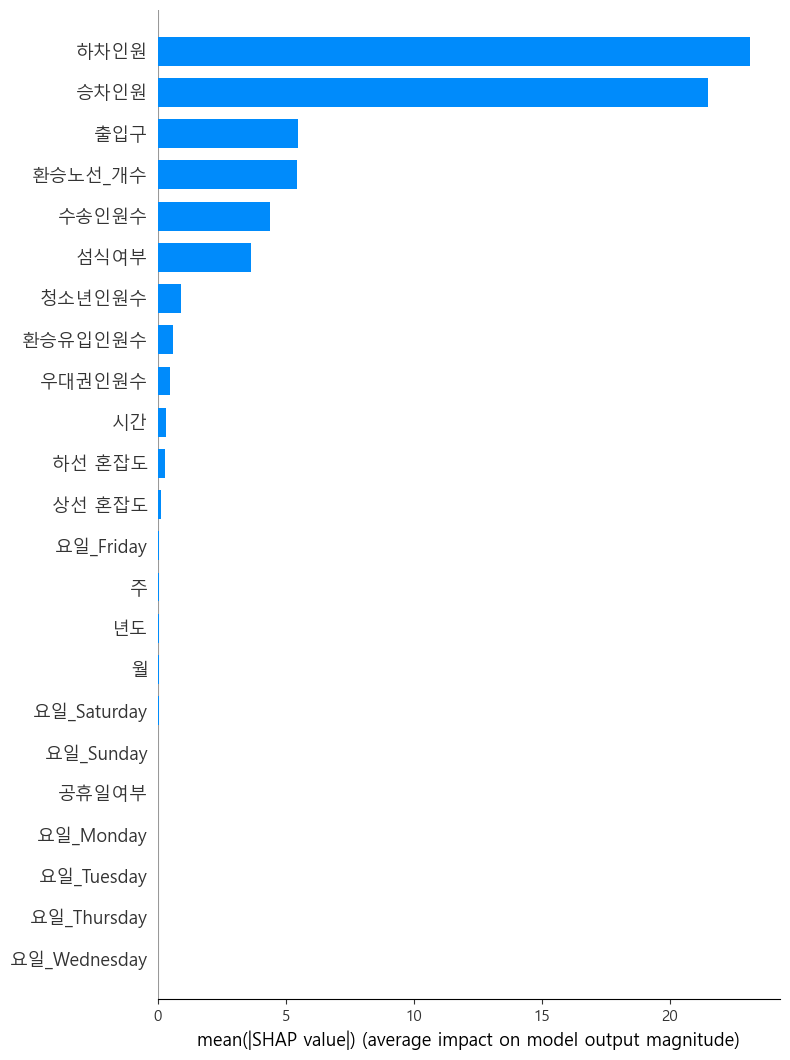

In [17]:
shap.summary_plot(shap_values, data['X_test'], feature_names=data['feature_columns'], plot_type="bar", max_display=100)

In [46]:
station_data[station_data['승강장_혼잡도']<0.01]

,날짜,호선,역명,시간,승차인원,하차인원,우대권인원수,청소년인원수,기온(°C),강수량(mm),...,λ_환승,λ_total,W_승차,W_환승,W_total,L_total,승강장_혼잡도,주,년도,월
45858,2021-04-04,2,강남,6,276,459,257,10,9.5,0.1,...,0.143146,12.393146,2.7975,1.5,2.782513,34.484094,0.005395,13,2021,4
234035,2022-04-21,2,강남,5,300,450,279,6,10.2,0.0,...,0.067051,12.567051,3.7500,1.5,3.737995,46.975577,0.007349,16,2022,4
80376,2021-06-13,2,강남,23,503,333,32,39,22.6,0.0,...,0.170016,14.103349,3.6425,1.5,3.616672,51.007191,0.007980,23,2021,6
218279,2022-03-20,2,강남,8,427,1035,134,51,4.2,0.0,...,0.256292,24.622959,2.5000,1.5,2.489591,61.301105,0.009590,11,2022,3
232067,2022-04-17,2,강남,6,323,473,294,2,7.2,0.0,...,0.133973,13.400640,2.7975,1.5,2.784528,37.314459,0.005838,15,2022,4
155216,2021-11-12,2,강남,5,326,444,292,3,2.4,0.0,...,0.069152,12.902485,3.7500,1.5,3.737941,48.228728,0.007545,45,2021,11
41915,2021-03-27,2,강남,5,212,239,184,4,11.1,0.0,...,0.063423,7.580089,3.6250,1.5,3.607220,27.343050,0.004278,12,2021,3
371858,2023-01-24,2,강남,6,352,409,261,13,-14.6,0.0,...,0.140758,12.824092,2.5725,1.5,2.560728,32.839013,0.005138,4,2023,1
80345,2021-06-13,2,강남,7,367,637,154,41,21.4,0.0,...,0.204182,16.937515,2.5575,1.5,2.544752,43.101773,0.006743,23,2021,6
23689,2021-02-18,2,강남,5,206,445,259,3,-10.4,0.0,...,0.058567,10.908567,3.7500,1.5,3.737920,40.775350,0.006379,7,2021,2


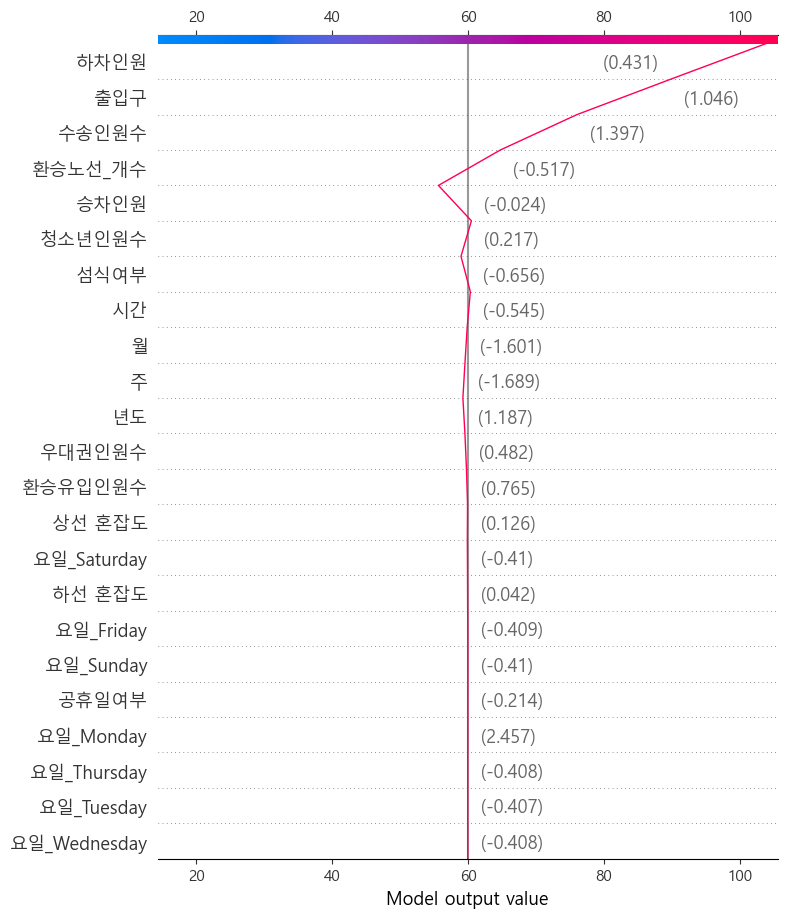

In [47]:
# 서울역 1호선
station_data = data['df_test'][(data['df_test']['역명'] == '강남') & (data['df_test']['호선'] == 2)]

instance_index = station_data[station_data['승강장_혼잡도']<0.01].index[9] 
X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
X_test_scaled_df = pd.DataFrame(X_test_station_scaled, columns=data['feature_columns'])

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_station_scaled)

# SHAP Decision Plot _첫 번째 인스턴스
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0],  
    features=X_test_scaled_df.iloc[0],  
    feature_names=data['feature_columns'],
    feature_display_range=slice(None, -99, -1)
)

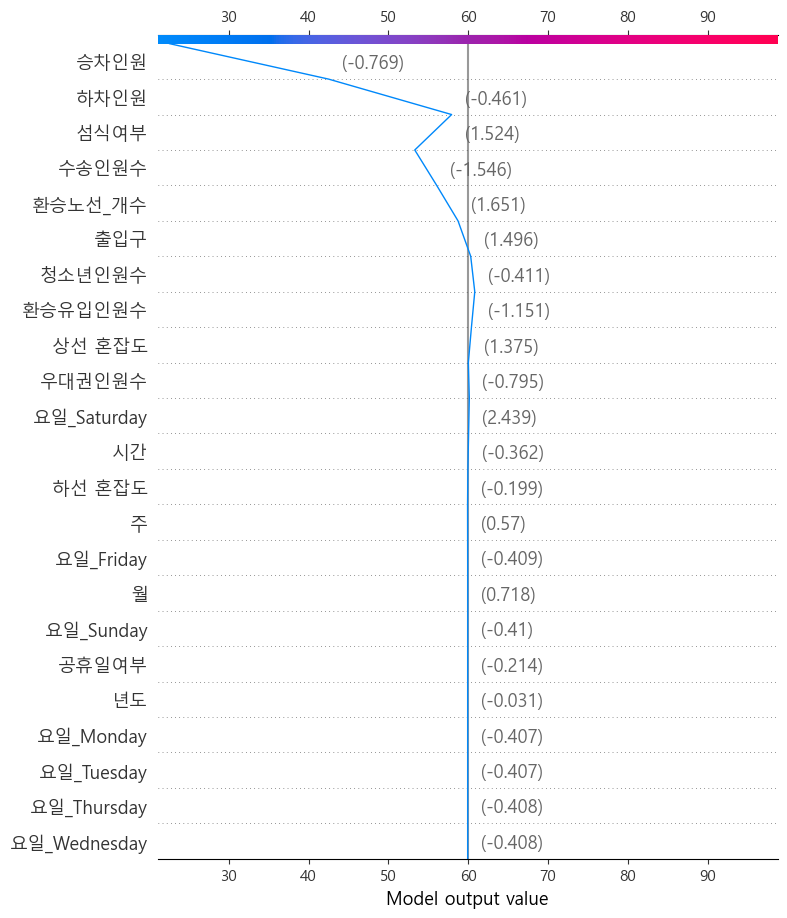

In [48]:
# 서울역 4호선
station_data = data['df_test'][(data['df_test']['역명'] == '서울역') & (data['df_test']['호선'] == 4)]

# station_data에서 첫 번째 데이터 포인트 사용
instance_index = station_data.index[0]  
X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
X_test_scaled_df = pd.DataFrame(X_test_station_scaled, columns=data['feature_columns'])

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_station_scaled)

# Decision Plot 
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0],  
    features=X_test_scaled_df.iloc[0],
    feature_names=data['feature_columns'],
    feature_display_range=slice(None, -99, -1)
)

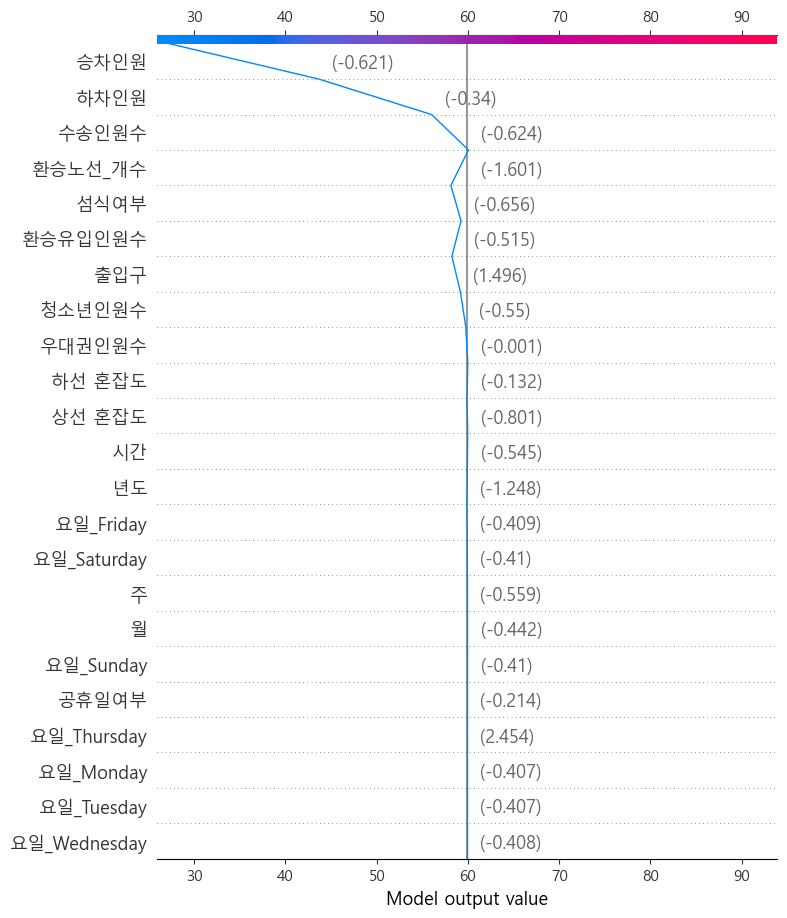

In [19]:
# 을지로 입구 2호선
station_data = data['df_test'][(data['df_test']['역명'] == '을지로입구') & (data['df_test']['호선'] == 2)]

# 첫 번째 데이터 포인트 사용
instance_index = station_data.index[955] 
X_test_station_scaled = data['scaler'].transform(station_data[data['feature_columns']])
X_test_scaled_df = pd.DataFrame(X_test_station_scaled, columns=data['feature_columns'])

# TreeExplainer 생성
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test_station_scaled)

# Decision Plot 
shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[0], 
    features=X_test_scaled_df.iloc[0],  
    feature_names=data['feature_columns'],
    feature_display_range=slice(None, -99, -1)
)